<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/src/K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K-Means Clustering Model

In [71]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

Loading dataset from Github repo

In [72]:
#Get preprocessed final table
cust_data = pd.read_csv('https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/profile_features.csv')
cust_data.head()

,Unnamed: 0,gender,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type
0,0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1230,1.0,2.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.01,3.333333,144.000000,5.0,5.0,0.00,0.500,25.67,0.002439,passive
1,1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1297,3.0,4.0,4.0,7.0,3.0,2.0,3.0,2.0,3.0,0.0,4.0,3.0,4.0,2.0,3.0,0.0,1.0,4.0,3.0,4.0,2.0,3.0,0.0,1.0,159.27,5.454545,137.454545,20.0,20.0,1.00,0.750,22.75,0.005397,active
2,2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,945,2.0,4.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,4.0,4.0,1.0,2.0,1.0,3.0,1.0,3.0,3.0,1.0,2.0,0.0,57.73,7.222222,184.000000,7.0,9.0,0.75,0.500,19.24,0.003175,passive
3,3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1021,5.0,6.0,6.0,3.0,5.0,3.0,5.0,5.0,3.0,2.0,6.0,3.0,6.0,6.0,4.0,2.0,0.0,6.0,3.0,6.0,6.0,4.0,2.0,0.0,36.43,6.764706,163.764706,19.0,24.0,1.00,0.833,12.14,0.002938,active
4,4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1111,1.0,3.0,2.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,2.0,3.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,15.62,7.333333,192.000000,2.0,5.0,0.67,0.333,3.90,0.003600,passive


In [73]:
cust_data.columns

Index(['Unnamed: 0', 'gender', 'age', 'cust_id', 'became_member_on', 'income',
       'days_as_member', 'Total offer completed', 'Total offer received',
       'Total offer viewed', 'Total transaction', 'offer completed_via_email',
       'offer completed_via_social', 'offer completed_via_mobile',
       'offer completed_via_web', 'offer completed bogo count',
       'offer completed discount count', 'offer received_via_email',
       'offer received_via_social', 'offer received_via_mobile',
       'offer received_via_web', 'offer received bogo count',
       'offer received discount count', 'offer received informational count',
       'offer viewed_via_email', 'offer viewed_via_social',
       'offer viewed_via_mobile', 'offer viewed_via_web',
       'offer viewed bogo count', 'offer viewed discount count',
       'offer viewed informational count', 'Total transaction amount',
       'avg_difficulty', 'avg_duration', 'total_reward_received',
       'total_reward_defined', 'total_view_

Adding label

In [74]:
#dropping columns that are not required for clustering
#select columns that are for clustering
cust_data['bogo_comp_perc'] = cust_data['offer completed bogo count'] / cust_data['Total offer completed']
cust_data['discount_comp_perc'] = cust_data['offer completed discount count'] / cust_data['Total offer completed']

cust_data['bogo_view_perc'] = cust_data['offer viewed bogo count'] / cust_data['Total offer viewed']
cust_data['discount_view_perc'] = cust_data['offer viewed discount count'] / cust_data['Total offer viewed']
cust_data['info_view_perc'] = cust_data['offer viewed informational count'] / cust_data['Total offer viewed']

cust_data['bogo_rec_perc'] = cust_data['offer received bogo count'] / cust_data['Total offer received']
cust_data['discount_rec_perc'] = cust_data['offer received discount count'] / cust_data['Total offer received']
cust_data['info_rec_perc'] = cust_data['offer received informational count'] / cust_data['Total offer received']

cust_data['bogo_comp_ratio'] = cust_data['offer completed bogo count'] / cust_data['offer received bogo count']
cust_data['discount_comp_ratio'] = cust_data['offer completed discount count'] / cust_data['offer received discount count']

cust_data['bogo_view_ratio'] = cust_data['offer viewed bogo count'] / cust_data['offer received bogo count']
cust_data['discount_view_ratio'] = cust_data['offer viewed discount count'] / cust_data['offer received discount count']
cust_data['info_view_ratio'] = cust_data['offer viewed informational count'] / cust_data['offer received informational count']

data = cust_data[['gender','age','income', 'days_as_member', 
'Total offer completed', 'Total offer received','Total offer viewed',
'offer completed bogo count', 'offer completed discount count', 'offer received bogo count', 'offer received discount count', 'offer received informational count', 'offer viewed bogo count', 'offer viewed discount count', 'offer viewed informational count',
'bogo_comp_perc','discount_comp_perc', 'bogo_view_perc','discount_view_perc', 'info_view_perc',
'bogo_rec_perc','discount_rec_perc', 'info_rec_perc',
'bogo_comp_ratio','discount_comp_ratio','bogo_view_ratio','discount_view_ratio', 'info_view_ratio',
'avg_difficulty','avg_duration', 'total_reward_received', 'avg_transaction_amt']]

data.sample(5)
# cust_data.sample(5)

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
797,F,91,37000.0,1199,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.50,0.50,0.500000,0.500000,0.0,0.5,0.5,0.0,1.000000,1.0,1.0,1.000000,NaN,10.000000,204.000000,12.0,10.34
4742,F,57,98000.0,977,2.0,3.0,3.0,2.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.00,0.00,1.000000,0.000000,0.0,1.0,0.0,0.0,0.666667,NaN,1.0,NaN,NaN,6.250000,120.000000,10.0,29.77
10457,M,45,45000.0,1469,4.0,5.0,3.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,0.0,0.25,0.75,0.333333,0.666667,0.0,0.2,0.6,0.2,1.000000,1.0,1.0,0.666667,0.0,7.166667,168.000000,12.0,10.67
2838,F,65,78000.0,1912,4.0,5.0,5.0,3.0,1.0,4.0,1.0,0.0,4.0,1.0,0.0,0.75,0.25,0.800000,0.200000,0.0,0.8,0.2,0.0,0.750000,1.0,1.0,1.000000,NaN,8.928571,157.714286,27.0,19.16
6259,M,49,31000.0,1186,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,1.000000,0.000000,0.0,0.5,0.5,0.0,0.000000,0.0,1.0,0.000000,NaN,10.000000,168.000000,0.0,3.16


In [75]:
data.shape

(14825, 32)

In [76]:
#Conerting genders into numeric data
data['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [77]:
data['gender'].replace({'M':0, 'F':1,'O':2}, inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
0,1,55,112000.0,1230,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.500000,0.000000,0.500000,1.00,NaN,0.0,NaN,0.0,3.333333,144.000000,5.0,25.67
1,1,75,100000.0,1297,3.0,4.0,4.0,3.0,0.0,3.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.750000,0.000000,0.25,0.750000,0.000000,0.250000,1.00,NaN,1.0,NaN,1.0,5.454545,137.454545,20.0,22.75
2,0,68,70000.0,945,2.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.5,0.5,0.333333,0.666667,0.00,0.250000,0.500000,0.250000,1.00,0.5,1.0,1.0,0.0,7.222222,184.000000,7.0,19.24
3,0,65,53000.0,1021,5.0,6.0,6.0,3.0,2.0,4.0,2.0,0.0,4.0,2.0,0.0,0.6,0.4,0.666667,0.333333,0.00,0.666667,0.333333,0.000000,0.75,1.0,1.0,1.0,NaN,6.764706,163.764706,19.0,12.14
4,0,58,51000.0,1111,1.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.000000,1.000000,0.00,0.000000,0.666667,0.333333,NaN,0.5,NaN,1.0,0.0,7.333333,192.000000,2.0,3.90


In [78]:
#Filling in avg_amount null values with Imputer
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy = 'median')
data_imp = pd.DataFrame(imputer.fit_transform(data))

In [79]:
data.shape

(14825, 32)

In [80]:
#Standardscaler to scale the data
data_scaled = StandardScaler().fit_transform(data_imp)
data_scaled

array([[ 1.06355702,  0.03488876,  2.15741893, ..., -0.53950967,
        -0.62221469,  0.65169175],
       [ 1.06355702,  1.18543027,  1.60180089, ..., -0.79136381,
         1.01514395,  0.47484409],
       [-0.84253979,  0.78274074,  0.2127558 , ...,  0.99959896,
        -0.40390021,  0.2622635 ],
       ...,
       [-0.84253979, -0.31027369,  0.35166031, ..., -1.46297485,
        -1.16800091, -0.60198861],
       [ 1.06355702,  1.64564687, -0.71327427, ..., -0.23168795,
         1.56093017, -0.08234718],
       [ 1.06355702,  0.43757829,  0.76837384, ..., -1.00124226,
        -0.29474296,  0.54085914]])

In [81]:
data_cluster = pd.DataFrame(data_scaled, columns = data.columns).dropna()
data_cluster.head()

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt
0,1.063557,0.034889,2.157419,-0.349433,-0.742678,-2.313047,-2.604592,-0.017517,-1.050678,-0.707758,-1.591813,0.117481,-1.414305,-1.220437,-0.827778,1.674916,-1.674916,0.175555,-0.115927,-0.798382,0.417697,-1.663723,1.534467,1.020112,0.768385,-3.037058,0.735129,-2.287517,-1.819481,-0.539510,-0.622215,0.651692
1,1.063557,1.185430,1.601801,-0.189601,0.534237,-0.451989,0.493128,1.871174,-1.050678,1.083996,-1.591813,0.117481,1.439781,-1.220437,0.483312,1.674916,-1.674916,1.021875,-1.284219,0.287776,1.458629,-1.663723,0.257448,1.020112,0.768385,0.521835,0.735129,0.514554,-0.958991,-0.791364,1.015144,0.474844
2,-0.842540,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.096256,-0.096256,-0.388658,1.052365,-0.798382,-0.623234,0.412203,0.257448,1.020112,-0.438504,0.521835,0.735129,-2.287517,-0.241916,0.999599,-0.403900,0.262264
3,-0.842540,0.610160,-0.574370,-0.848012,1.811152,1.409069,2.041988,1.871174,0.785067,1.979873,0.178261,-1.024585,2.391143,0.739693,-0.827778,0.411988,-0.411988,0.739768,-0.115927,-0.798382,1.111652,-0.279773,-1.019571,0.413895,0.768385,0.521835,0.735129,0.514554,-0.427512,0.220991,0.905987,-0.167743
4,-0.842540,0.207470,-0.666973,-0.633313,-0.742678,-1.382518,-1.055732,-0.961863,-0.132805,-1.603635,0.178261,0.117481,-1.414305,0.739693,-0.827778,-1.482403,1.482403,-1.517085,2.220657,-0.798382,-1.664166,1.104178,0.683121,0.211823,-0.438504,0.521835,0.735129,-2.287517,-0.196843,1.307421,-0.949686,-0.666792


### K Means Clustering to find the number of Customer clusters

In [82]:
#choosing value of k as 12
##for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
scores = []
K_values = range(1,12)
for k in K_values:
    k_means = KMeans(n_clusters = k)
    model = k_means.fit(data_cluster)
    scores.append(k_means.inertia_)

In [83]:
scores

[474400.0,
 396850.4800889674,
 351427.7929797741,
 321169.66397132963,
 303985.6624643604,
 293140.60019049916,
 283790.08861570153,
 275908.7738634829,
 269085.9677621583,
 262125.93060239006,
 256372.84746850535]

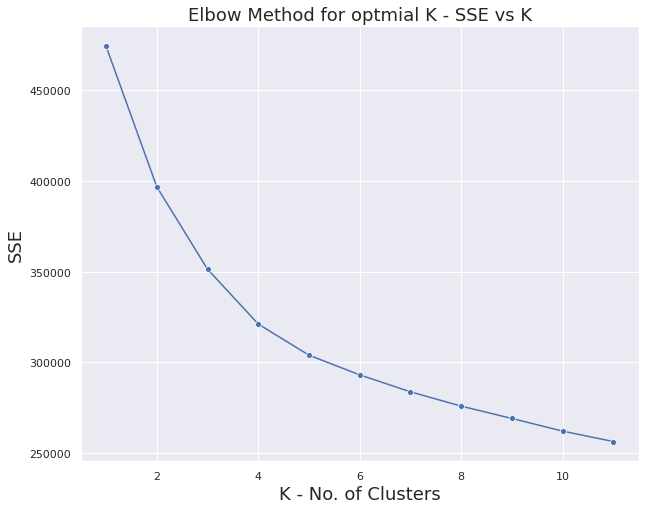

In [84]:
#Elbow plot with a line graph
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.set_style('darkgrid')
chart=sns.lineplot(ax=ax, x=K_values, y =scores, marker="o")
plt.xlabel("K - No. of Clusters", fontsize=18)
plt.ylabel("SSE", fontsize =18)
plt.title("Elbow Method for optmial K - SSE vs K", fontsize =18)

plt.show(chart)

### From the above graph we see that the elbow point could be at k=2 or 4


In [85]:
#Calcluate silhouette_score and calinski_harabasz_score for cluster 2 tp 10
for i in range(2,10):
    k_means = KMeans(n_clusters = i)
    k_means.fit(data_cluster)
    labels = k_means.labels_
    sc = metrics.silhouette_score(data_cluster, labels, metric = 'euclidean')
    ch = metrics.calinski_harabasz_score(data_cluster, labels)
    print("k = ",i,", The silhouette_score is :", sc, "Calinski Harabasz Score is: ",ch)


k =  2 , The silhouette_score is : 0.1484976225472522 Calinski Harabasz Score is:  2896.604090204035
k =  3 , The silhouette_score is : 0.14268324990044368 Calinski Harabasz Score is:  2593.2841253881365
k =  4 , The silhouette_score is : 0.14292577810506488 Calinski Harabasz Score is:  2357.0360525109913
k =  5 , The silhouette_score is : 0.12362458699090904 Calinski Harabasz Score is:  2077.0241393907518
k =  6 , The silhouette_score is : 0.1160944418566785 Calinski Harabasz Score is:  1832.6303960492164
k =  7 , The silhouette_score is : 0.10260479142473673 Calinski Harabasz Score is:  1654.7577957169347
k =  8 , The silhouette_score is : 0.10107478254554439 Calinski Harabasz Score is:  1526.67858212986
k =  9 , The silhouette_score is : 0.10248382292766377 Calinski Harabasz Score is:  1411.7363129343642


### Based on the scores and the elbow point , we'll choose k=4 clusters. After k=4 both the scores drop considerably for the remaning clusters

###Predict and Visualize the clusters for k=4



In [86]:
km = KMeans(
    n_clusters=4)#, #init='random',
  #  n_init=10, max_iter=300, #n_init runs the kmeans algm 10 times to choose model with lowest SSE
  #  tol=1e-04, random_state=0
#).fit(data_cluster)
y_km = km.fit_predict(data_cluster)

In [87]:
np.unique(y_km)

array([0, 1, 2, 3], dtype=int32)

In [88]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [89]:
data_pred = data_cluster
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(data_cluster))

data_pred['cluster'] = y_km
data_mean = data_pred.groupby('cluster').mean()

In [90]:
data_pred

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,cluster
0,1.063557,0.034889,2.157419,-0.349433,-0.742678,-2.313047,-2.604592,-0.017517,-1.050678,-0.707758,-1.591813,0.117481,-1.414305,-1.220437,-0.827778,1.674916,-1.674916,0.175555,-0.115927,-0.798382,0.417697,-1.663723,1.534467,1.020112,0.768385,-3.037058,0.735129,-2.287517,-1.819481,-0.539510,-0.622215,0.651692,1
1,1.063557,1.185430,1.601801,-0.189601,0.534237,-0.451989,0.493128,1.871174,-1.050678,1.083996,-1.591813,0.117481,1.439781,-1.220437,0.483312,1.674916,-1.674916,1.021875,-1.284219,0.287776,1.458629,-1.663723,0.257448,1.020112,0.768385,0.521835,0.735129,0.514554,-0.958991,-0.791364,1.015144,0.474844,2
2,-0.842540,0.782741,0.212756,-1.029314,-0.104220,-0.451989,-0.281302,-0.017517,-0.132805,-0.707758,0.178261,0.117481,-0.462943,0.739693,-0.827778,0.096256,-0.096256,-0.388658,1.052365,-0.798382,-0.623234,0.412203,0.257448,1.020112,-0.438504,0.521835,0.735129,-2.287517,-0.241916,0.999599,-0.403900,0.262264,0
3,-0.842540,0.610160,-0.574370,-0.848012,1.811152,1.409069,2.041988,1.871174,0.785067,1.979873,0.178261,-1.024585,2.391143,0.739693,-0.827778,0.411988,-0.411988,0.739768,-0.115927,-0.798382,1.111652,-0.279773,-1.019571,0.413895,0.768385,0.521835,0.735129,0.514554,-0.427512,0.220991,0.905987,-0.167743,2
4,-0.842540,0.207470,-0.666973,-0.633313,-0.742678,-1.382518,-1.055732,-0.961863,-0.132805,-1.603635,0.178261,0.117481,-1.414305,0.739693,-0.827778,-1.482403,1.482403,-1.517085,2.220657,-0.798382,-1.664166,1.104178,0.683121,0.211823,-0.438504,0.521835,0.735129,-2.287517,-0.196843,1.307421,-0.949686,-0.666792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1.063557,-0.540382,-0.528068,-1.122350,-1.381135,-1.382518,-0.281302,-0.961863,-1.050678,-0.707758,-0.706776,0.117481,-0.462943,-0.240372,0.483312,0.096256,-0.096256,-0.388658,-0.115927,0.649829,-0.276257,-0.279773,0.683121,-1.404753,-1.645394,0.521835,0.735129,0.514554,-0.872942,-1.462975,-1.168001,-0.729779,1
14821,-0.842540,0.380051,0.305359,-1.215386,-0.742678,-1.382518,-1.830162,-0.017517,-1.050678,-0.707758,-1.591813,1.259546,-1.414305,-1.220437,0.483312,1.674916,-1.674916,-1.517085,-1.284219,3.546253,-0.276257,-1.663723,2.385814,1.020112,0.768385,-3.037058,0.735129,-0.886481,-2.360360,-1.647668,-0.622215,-0.678300,1
14822,-0.842540,-0.310274,0.351660,0.056110,-1.381135,-1.382518,-1.830162,-0.961863,-1.050678,-1.603635,-0.706776,1.259546,-1.414305,-1.220437,0.483312,0.096256,-0.096256,-1.517085,-1.284219,3.546253,-1.664166,-0.279773,2.385814,0.211823,-1.645394,0.521835,-2.013090,-0.886481,-1.143381,-1.462975,-1.168001,-0.601989,1
14823,1.063557,1.645647,-0.713274,0.831413,0.534237,-1.382518,-0.281302,1.871174,-1.050678,1.083996,-1.591813,-1.024585,1.439781,-1.220437,-0.827778,1.674916,-1.674916,1.868195,-1.284219,-0.798382,2.499560,-1.663723,-1.019571,1.020112,0.768385,0.521835,0.735129,0.514554,0.208817,-0.231688,1.560930,-0.082347,2


###t-distributed Stochastic Neighbor Embedding (t-SNE) for visualizing the clusters

In [91]:
from sklearn.manifold import TSNE
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

In [97]:
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    size = (10, 8)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    #ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [93]:
tsne_3d_df = prepare_tsne(3, data_cluster, y_km)


In [94]:
tsne_3d_df

,x,y,z,labels
0,-17.297401,3.953348,-15.797326,1
1,-26.968252,-0.404363,-5.185318,2
2,21.549301,-10.428013,6.900151,0
3,-8.317981,-5.959802,-7.021574,2
4,22.317270,0.298998,12.605206,0
...,...,...,...,...
14820,17.674238,19.374144,-0.706074,1
14821,-20.961443,12.154680,-9.015660,1
14822,10.120420,23.023434,11.812623,1
14823,-18.157795,-10.328089,-16.665253,2


In [95]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


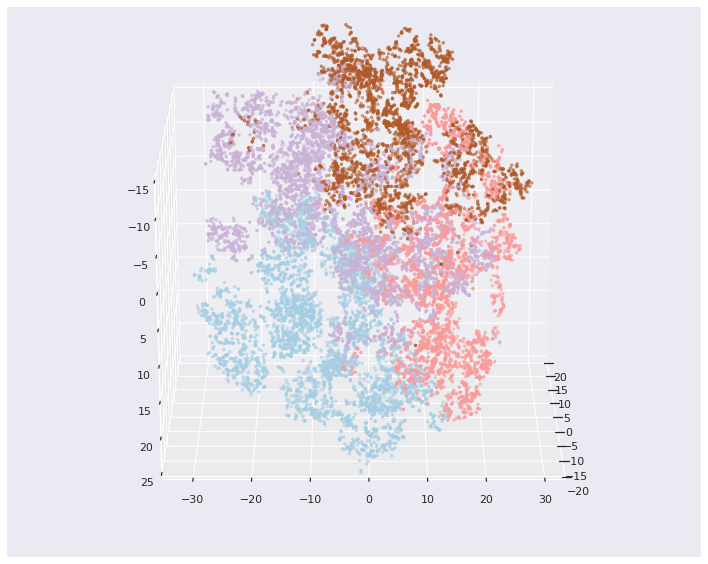

In [98]:
from matplotlib import rc
plot_animation(tsne_3d_df, 'labels', 'labels')

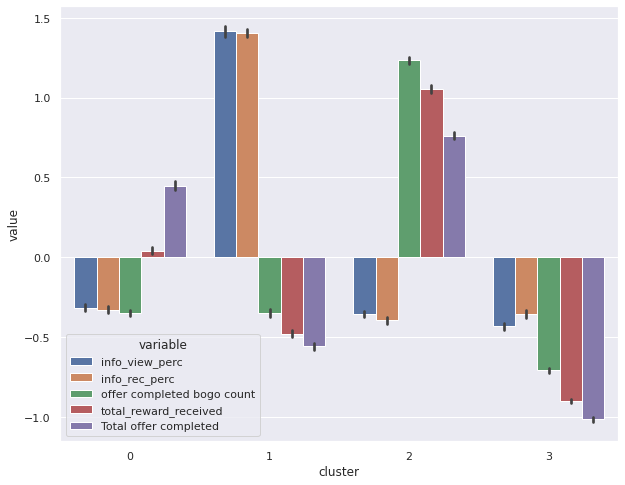

In [99]:
#Finding and plotting the top 5 features used in clustering
results = pd.DataFrame(columns=['Variable', 'Var'])
for column in data_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.var(data_mean[column])]
selected_columns = list(results.sort_values('Var', ascending=False,).head(5).Variable.values) + ['cluster']
tidy = data_pred[selected_columns].melt(id_vars='cluster')
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x='cluster', y='value', hue='variable', data=tidy)

###Visualizing the clusters based on deographic data

Cluster 0 - Red, Cluster 1 - Blue, Cluster 2 - Green, Cluster 3 - Purple

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


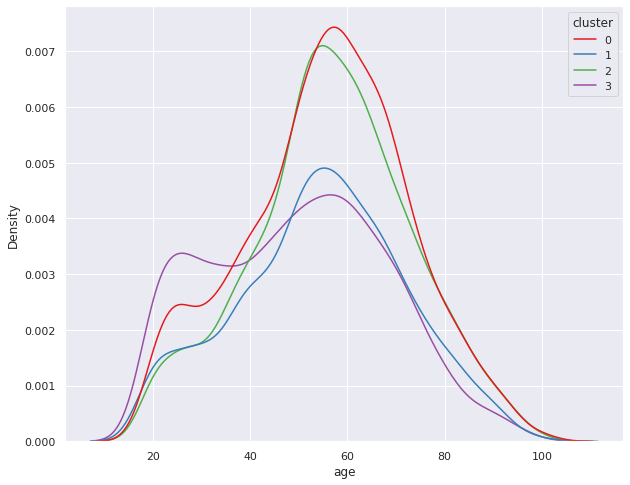

In [100]:
#Adding cluster to original data
data['cluster'] = y_km
size = (10, 8)
fig, ax = plt.subplots(figsize=size)

#Visualizing clusters across age ranges
sns.kdeplot(data = data, x='age', hue='cluster', palette="Set1" )

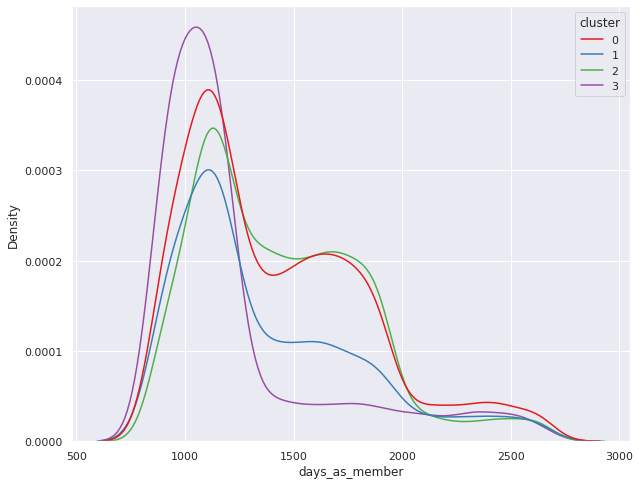

In [101]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(data = data, x='days_as_member', hue='cluster', palette="Set1",ax=ax )

Text(14.055409523809516, 0.5, 'Income')

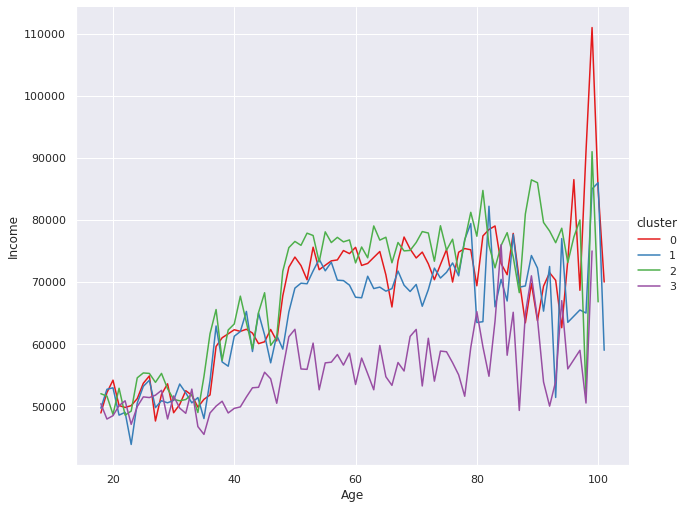

In [166]:
sns.relplot(data = data, x = 'age', y = 'income', hue = 'cluster', palette = 'Set1', kind = "line", ci=None, height=7, aspect=1.25)
plt.xlabel('Age')
plt.ylabel('Income')

([<matplotlib.axis.XTick at 0x7fa72143aa58>,
 [Text(0, 0, 'Male'), Text(0, 0, 'Female'), Text(0, 0, 'Other')])

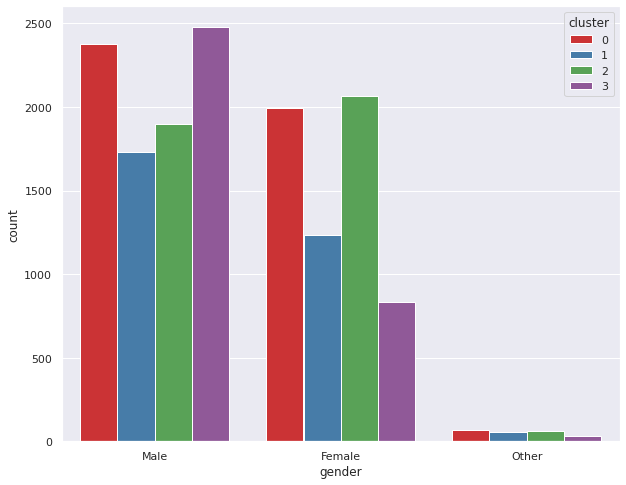

In [103]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.countplot(data = data, x = 'gender', hue = 'cluster', ax = ax, palette='Set1')
plt.xticks(range(3), ['Male', 'Female', 'Other'])

###Based on response to offers

In [104]:
data

,gender,age,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,offer completed bogo count,offer completed discount count,offer received bogo count,offer received discount count,offer received informational count,offer viewed bogo count,offer viewed discount count,offer viewed informational count,bogo_comp_perc,discount_comp_perc,bogo_view_perc,discount_view_perc,info_view_perc,bogo_rec_perc,discount_rec_perc,info_rec_perc,bogo_comp_ratio,discount_comp_ratio,bogo_view_ratio,discount_view_ratio,info_view_ratio,avg_difficulty,avg_duration,total_reward_received,avg_transaction_amt,cluster
0,1,55,112000.0,1230,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.500000,0.000000,0.500000,1.00,NaN,0.0,NaN,0.0,3.333333,144.000000,5.0,25.67,1
1,1,75,100000.0,1297,3.0,4.0,4.0,3.0,0.0,3.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.750000,0.000000,0.250000,0.750000,0.000000,0.250000,1.00,NaN,1.0,NaN,1.0,5.454545,137.454545,20.0,22.75,2
2,0,68,70000.0,945,2.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.5,0.5,0.333333,0.666667,0.000000,0.250000,0.500000,0.250000,1.00,0.5,1.0,1.0,0.0,7.222222,184.000000,7.0,19.24,0
3,0,65,53000.0,1021,5.0,6.0,6.0,3.0,2.0,4.0,2.0,0.0,4.0,2.0,0.0,0.6,0.4,0.666667,0.333333,0.000000,0.666667,0.333333,0.000000,0.75,1.0,1.0,1.0,NaN,6.764706,163.764706,19.0,12.14,2
4,0,58,51000.0,1111,1.0,3.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.666667,0.333333,NaN,0.5,NaN,1.0,0.0,7.333333,192.000000,2.0,3.90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,45,54000.0,906,0.0,3.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.00,0.0,1.0,1.0,1.0,5.666667,120.000000,0.0,2.86,1
14821,0,61,72000.0,867,1.0,3.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,1.000000,0.333333,0.000000,0.666667,1.00,NaN,0.0,NaN,0.5,2.000000,115.200000,5.0,3.71,1
14822,0,49,73000.0,1400,0.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.333333,0.666667,NaN,0.0,NaN,0.0,0.5,5.000000,120.000000,0.0,4.97,1
14823,1,83,50000.0,1725,3.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00,NaN,1.0,NaN,NaN,8.333333,152.000000,25.0,13.55,2


Text(0.5, 0, 'bogo_comp_ratio')

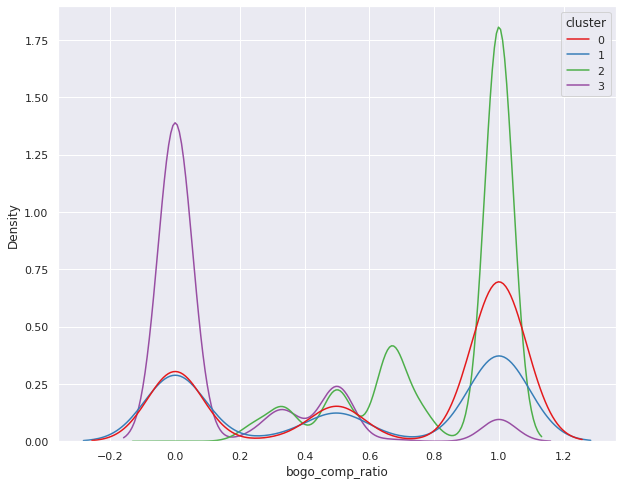

In [147]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'bogo_comp_ratio', hue = 'cluster', palette = 'Set1',)
plt.xlabel('bogo_comp_ratio')

Text(0.5, 0, 'bogo_view_ratio')

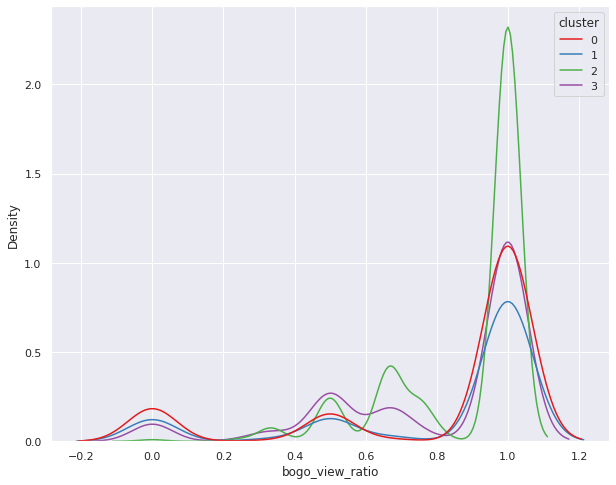

In [148]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'bogo_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.xlabel('bogo_view_ratio')

Text(0.5, 0, 'discount_comp_ratio')

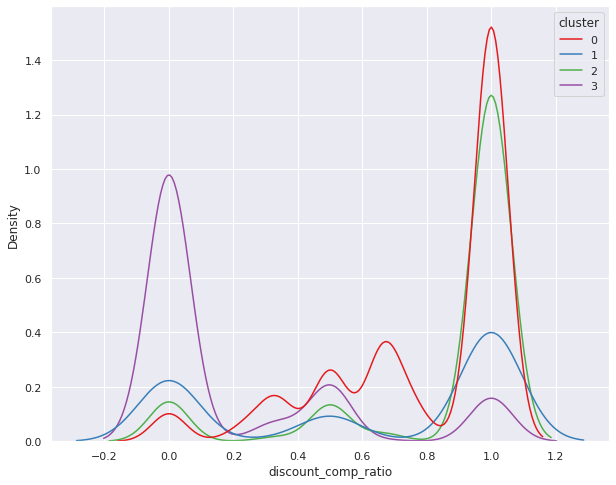

In [149]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'discount_comp_ratio', hue = 'cluster', palette = 'Set1',)
plt.xlabel('discount_comp_ratio') 

Text(0.5, 0, 'discount_view_ratio')

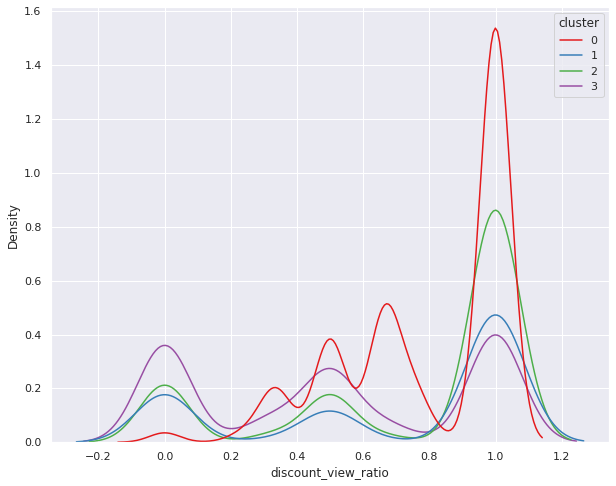

In [150]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'discount_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.xlabel('discount_view_ratio')

Text(0.5, 0, 'info_view_ratio')

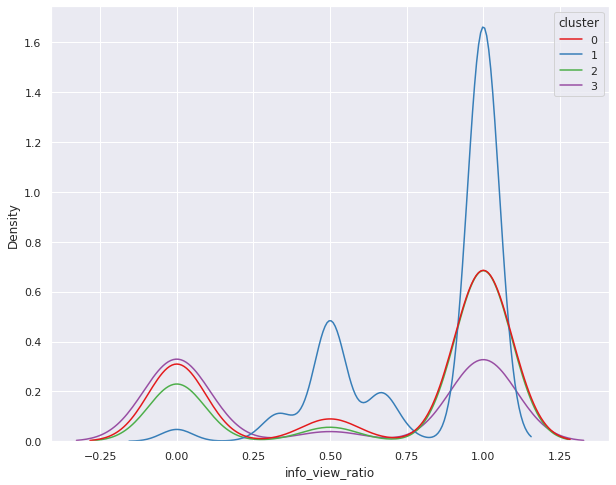

In [151]:
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
sns.kdeplot(ax=ax, data = data, x = 'info_view_ratio', hue = 'cluster', palette = 'Set1',)
plt.xlabel('info_view_ratio')

Cluster 0- This cluster contains the most number of people, and it also includes a higher number ofthe older population with age greater than 60. While the income spread follows the generalcorrelation with age, it seems like the customers in this cluster strongly prefer completing discountoffers as compared to BOGO ones.

Cluster 1- Containing the least number of customers, this cluster is made up of middle-incomeearners who seem to be the least responsive both in terms of viewing the offers and completing them.The only action they perform better than the rest are viewing the informational offers.

Cluster 2- The only cluster that contains more female customers than male, it is made up ofrelatively higher income earners. This cluster consists of the most active customers, completing ahigh percentage of offers with a noticeably higher preference to BOGO offers as compared todiscount offers.

Cluster 3- Consists of a high ratio of male customers as compared to females, and possesses manyof the younger population of the customer base with age less than 30 years. The average income ofthe people belonging to this cluster is also significantly lower than other clusters. This reflects intheir offer responsiveness as their offer view percentages are very high (could be due to their highusage of mobile phones and internet) but they do not complete the many of the offers provided tothem (could be due to their economic situation)